In [21]:
reset -fs

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [23]:
raw_national = pd.read_csv("../data/StateNames.csv")
raw_national.shape

(5647426, 6)

In [24]:
# more than 5M rows, let's choose a sample
raw_nat_sample = raw_national.sample(n=100000)
raw_nat_sample.shape

(100000, 6)

In [25]:
# take a look
raw_nat_sample.columns = map(lambda x : x.lower().replace(' ','_').replace('count','nb_count'),raw_nat_sample.columns)
raw_nat_sample.head(10)

,id,name,year,gender,state,nb_count
2592933,2592934,Cordell,1965,M,MI,5
4688766,4688767,Kaitlyn,2010,F,TN,70
1736385,1736386,Grace,1912,F,IN,93
4518801,4518802,Kinsey,2006,F,SC,7
883007,883008,Nathaniel,2008,M,CT,80
2566534,2566535,Russel,1916,M,MI,13
4511043,4511044,Ashtyn,1995,F,SC,6
2294597,2294598,Milton,1980,M,MA,5
5174678,5174679,Charlotte,1944,F,VA,168
3088589,3088590,Natalya,1998,F,NC,6


In [26]:
raw_nat_sample.sort_values(by=['name','year','state','nb_count'],ascending=False)

,id,name,year,gender,state,nb_count
3184377,3184378,Zyon,2013,M,NC,10
5293586,5293587,Zyon,2012,M,VA,12
4926798,4926799,Zyon,2011,F,TX,5
4750043,4750044,Zyon,2011,M,TN,5
5062821,5062822,Zyon,2009,M,TX,14
1314671,1314672,Zyon,2006,M,GA,19
5040417,5040418,Zyon,1999,M,TX,7
142274,142275,Zyon,1999,M,AL,5
560931,560932,Zylah,2013,F,CA,6
3106279,3106280,Zykeria,2010,F,NC,6


In [27]:
# prepare unique (name, year, count) and aggregate different state, drop column['id']

from IPython.display import display

name_year_count = raw_nat_sample.groupby(['name','year']).sum().drop(['id'],axis=1)
print(name_year_count.shape)
name_year_count.head()

(78521, 1)


nb_count
name   year          
Aaden  2008        77
       2009        20
       2010        20
Aadhya 2014         7
Aaiden 2013        13

In [28]:
# reset index to transform multi-index into columns
name_year_count.reset_index(inplace=True)
print(name_year_count.shape)
name_year_count.head()

(78521, 3)


,name,year,nb_count
0,Aaden,2008,77
1,Aaden,2009,20
2,Aaden,2010,20
3,Aadhya,2014,7
4,Aaiden,2013,13


In [29]:
# crosstab name and year
year_name_crosstab = pd.crosstab(index=name_year_count.year,columns=name_year_count.name,values=name_year_count.nb_count,aggfunc=np.sum)

In [30]:
# find names with most long history data
name_histroy_length = {c:year_name_crosstab[c].count() for c in year_name_crosstab.columns}
names_with_long_history_sorted = sorted(name_histroy_length, key=name_histroy_length.get, reverse=True)

James


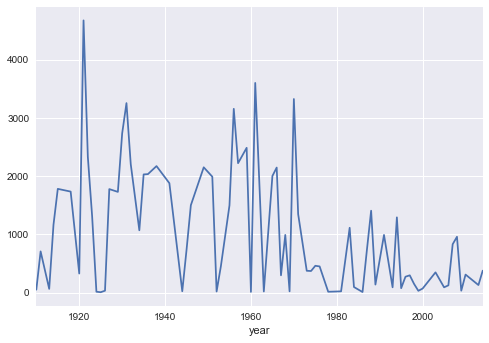

In [31]:
# print the name with longest history
print(names_with_long_history_sorted[0])
year_name_crosstab[names_with_long_history_sorted[0]].dropna().plot(kind='line');

In [65]:
# build Series for name: average_yearly_count
name_yearly_freq = year_name_crosstab.mean(axis=0).sort_values(ascending=False)

print(name_yearly_freq.index[:5],name_yearly_freq[:5])

Index(['John', 'William', 'Robert', 'Mary', 'James'], dtype='object', name='name') name
John       1319.694444
William    1091.895522
Robert     1066.783784
Mary       1029.222222
James      1021.760000
dtype: float64


In [ ]:
# import matplotlib.pyplot as plt
# ax = name_year_count[['name','nb_count']].head(100).plot(kind='bar', title ="name total count", figsize=(15, 10), legend=True, fontsize=12)
# ax.set_xlabel("name", fontsize=12)
# ax.set_ylabel("count", fontsize=12)
# plt.show()

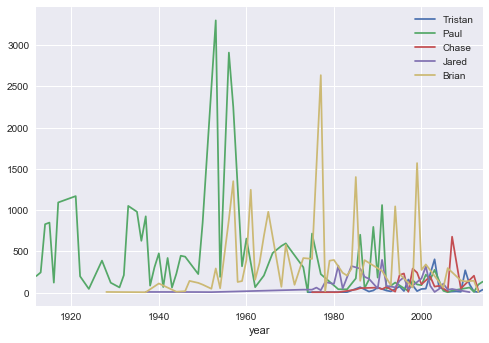

In [71]:
def print_name_trend(names):
    """ Given a list of names, plot name yearly frequency trend"""
    plt.figure()
    for name in names:
        year_name_crosstab[name].dropna().plot(kind='line');
    plt.legend(names)

# print_name_trend(name_yearly_freq.index[:3])

print_name_trend(['Tristan','Paul','Chase','Jared','Brian'])